Optimize the circuit for number of T gates

In [2]:
import pennylane as pl
import matplotlib.pyplot as plt 
import numpy as np 

### Prepare state using Mottogen State Prep

In [3]:
v = np.array([0.52889389-0.14956775j, 0.67262317+0.49545818j])
import pennylane as qml

device = pl.device('default.qubit', wires=1)

@qml.qnode(device)
def prepare_state(state=v):
    qml.MottonenStatePreparation(state_vector=state/np.linalg.norm(state), wires=0)
    return qml.state()

print(prepare_state(v))

[0.49365933-0.24166034j 0.75032489+0.36730546j]


In [4]:
v = np.array([1/2, 1j*np.sqrt(3)/2])
import pennylane as qml

device = pl.device('default.qubit', wires=1)

@qml.qnode(device)
def prepare_state():
    qml.RX(-2*np.pi/3, wires=0)
    qml.adjoint(qml.S)(wires=0)
    qml.Hadamard(0)
    return qml.state()

print(prepare_state())

[ 0.96592583+0.j -0.25881905+0.j]


### Compute expectation values

In [5]:
dev = qml.device("default.qubit", wires=1, shots=100000)

@qml.qnode(dev)
def circuit():
    qml.RX(np.pi/4, wires=0)
    qml.Hadamard(wires=0)
    qml.PauliZ(wires=0)

    return qml.sample(qml.PauliY(wires=0))

def compute_expval_from_samples(samples):
    estimated_expval = 0
    samples = list(samples)
    estimated_expval = ((samples.count(1)+((-1)*samples.count(-1)))/100000)

    return estimated_expval

samples = circuit()
print(compute_expval_from_samples(samples))


-0.7068


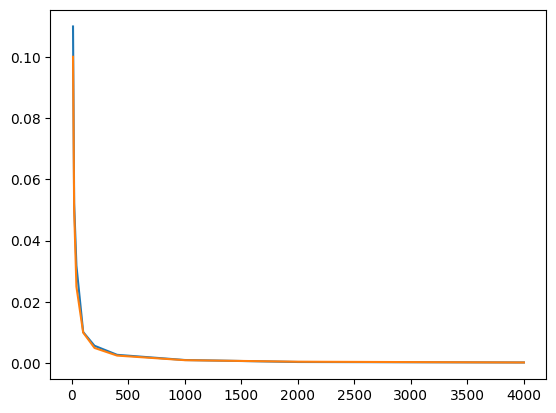

In [13]:

def variance_experiment(n_shots):
    n_trials = 100
    dev = qml.device("default.qubit", wires=1, shots=n_shots)

    @qml.qnode(dev)
    def circuit():
        qml.Hadamard(wires=0)
        return qml.expval(qml.PauliZ(wires=0))

    trials = []
    
    for i in range(n_trials):
        trials.append(qml.QNode(circuit, dev)())
    
    return np.var(trials) 

def variance_scaling(n_shots):
    return 1/n_shots

# Various numbers of shots; you can change this
shot_vals = [10, 20, 40, 100, 200, 400, 1000, 2000, 4000]

# Used to plot your results
results_experiment = [variance_experiment(shots) for shots in shot_vals]
results_scaling = [variance_scaling(shots) for shots in shot_vals]

plt.plot(shot_vals, results_experiment)
plt.plot(shot_vals, results_scaling)
plt.show()



### Basis embedding

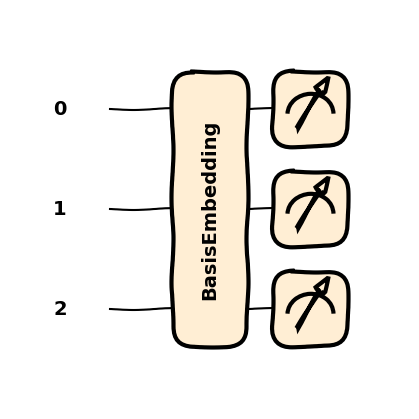

Output state = [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [ ]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def make_basis_state(basis_id):
    basis = [int(x) for x in np.binary_repr(basis_id,3)]
    qml.BasisEmbedding(features=basis, wires=range(3))
    return qml.state()

qnode = qml.QNode(make_basis_state, dev)(6)
qml.draw_mpl(make_basis_state, decimals=1, style="sketch", show_all_wires=True)(6)
plt.show()
basis_id = 1
print(f"Output state = {make_basis_state(basis_id)}")


In [ ]:
# I.11

# Creates a device with *two* qubits
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def two_qubit_circuit():
    qml.Hadamard(0)
    qml.PauliX(1)
    return [qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(1))]


print(two_qubit_circuit())


[tensor(0., requires_grad=True), tensor(-1., requires_grad=True)]


### Controlled rotation

In [ ]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def controlled_rotations(theta, phi, omega):
    qml.Hadamard(0)
    qml.CRX(theta, wires=[0,1])
    qml.CRY(phi, wires=[1,2])
    qml.CRZ(omega, wires=[2,0])
    return qml.probs(wires=[0,1,2])

theta, phi, omega = 0.1, 0.2, 0.3
print(controlled_rotations(theta, phi, omega))


[5.00000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.98751041e-01 0.00000000e+00 1.23651067e-03 1.24480103e-05]


In [ ]:
dev = qml.device("default.qubit", wires=2)

# Prepare a two-qubit state; change up the angles if you like
phi, theta, omega = 1.2, 2.3, 3.4


@qml.qnode(device=dev)
def true_cz(phi, theta, omega):
    # prepare_states(phi, theta, omega)
    qml.Hadamard(0)
    qml.CZ(wires=[0,1])
    
    return qml.state()


@qml.qnode(dev)
def imposter_cz(phi, theta, omega):
    qml.Hadamard(0)

    # prepare_states(phi, theta, omega)
    qml.Hadamard(1)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(1)
    return qml.state()


print(f"True CZ output state {true_cz(phi, theta, omega)}")
print(f"Imposter CZ output state {imposter_cz(phi, theta, omega)}")


True CZ output state [0.70710678+0.j 0.        +0.j 0.70710678+0.j 0.        +0.j]
Imposter CZ output state [0.70710678+0.j 0.        +0.j 0.70710678+0.j 0.        +0.j]


### CSWAP with CNOT gate

In [ ]:
dev = qml.device("default.qubit", wires=2)

# Prepare a two-qubit state; change up the angles if you like
phi, theta, omega = 1.2, 2.3, 3.4


@qml.qnode(dev)
def apply_swap(phi, theta, omega):
    qml.S(wires=0)
    qml.S(wires=1)
    qml.SWAP(wires=[0,1])

    return qml.state()


@qml.qnode(dev)
def apply_swap_with_cnots(phi, theta, omega):
    qml.S(wires=0)
    qml.S(wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])
    qml.CNOT(wires=[0,1])

    return qml.state()


print(f"Regular SWAP state = {apply_swap(phi, theta, omega)}")
print(f"CNOT SWAP state = {apply_swap_with_cnots(phi, theta, omega)}")


Regular SWAP state = [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
CNOT SWAP state = [1.+0.j 0.+0.j 0.+0.j 0.+0.j]


### MCX gate only with Toffoli gate.

result =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
10100 1.0


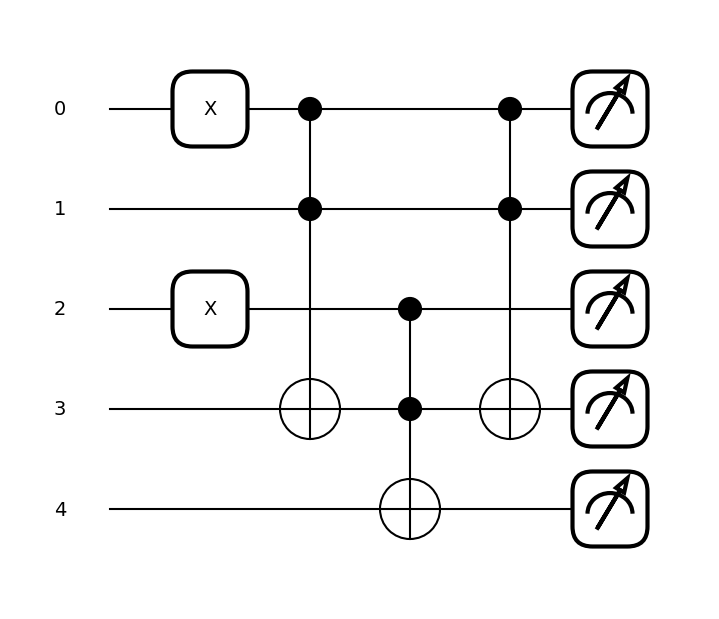

In [ ]:
# Wires 0, 1, 2 are the control qubits
# Wire 3 is the auxiliary qubit
# Wire 4 is the target 
dev = qml.device('default.qubit', wires=5)


@qml.qnode(dev)
def four_qubit_mcx_only_tofs():
    # We will initialize the control qubits in state |1> so you can see
    # how the output state gets changed.
    qml.PauliX(wires=0)
    # qml.PauliX(wires=1)
    qml.PauliX(wires=2)

    qml.Toffoli(wires=[0,1,3])
    qml.Toffoli(wires=[2,3,4])
    qml.Toffoli(wires=[0,1,3])
    
    return qml.probs(wires=[0,1,2,3,4])

res = qml.QNode(four_qubit_mcx_only_tofs, dev)()
print('result = ', res)
qml.draw_mpl(four_qubit_mcx_only_tofs)()
#print(four_qubit_mcx_only_tofs())

for i in range(32):
    if res[i] == 1:
        print(np.binary_repr(i, 5), res[i])
